# Stochastic Simulation

*Winter Semester 2024/25*

06.12.2024

Prof. Sebastian Krumscheid<br>
Assistants: Stjepan Salatovic, Louise Kluge

<h3 align="center">
Exercise sheet 05
</h3>

---

<h1 align="center">
The Monte Carlo method
</h1>

In [1]:
import matplotlib.pylab as plt
import numpy as np

from ipywidgets import interact
from scipy.special import factorial
from scipy.stats import uniform, norm, pareto, lognorm, rv_continuous
from scipy.optimize import newton
from typing import Callable, Tuple
from tqdm.notebook import tqdm

In [2]:
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

## Exercise 1

Let $X = [X_1, X_2, ..., X_n] \overset{\text{i.i.d}}{\sim} \mathcal{U}([-1,1]^n)$ be a random vector uniformly distributed over the $n$-dimensional square $\Gamma=[-1,1]^n$, and define the random variable $Z=\mathbb{1}_{\|X\|_{l^2}<1}.$ Observe that

\begin{align*}
I=\mathbb{E}[Z]=\int_\Gamma \mathbb{1}_{\|x\|_{l^2}<1}p(x)\mathrm{d}x=\frac{1}{|\Gamma|}\left|B(0,1)\right|,
\end{align*}

where $p(x)$ is the PDF of $\mathcal{U}([-1,1]^n),$ and $\left|B(0,1)\right|$ is the volume of the $n$-dimensional sphere with center $0$ and radius $1$. 

1. Let $n=2$. Use Monte Carlo to approximate the value of $I$:
$$
\overline{I}_N := \frac{1}{N} \sum_{k=1}^N Z_k
$$
For $N=10,100,1000,10000,$ compute $\overline{I}_N$ as well as an approximate confidence interval and compare with the exact value $I$. In addition, plot the relative error $\frac{|\overline I_N -I|}{I}$ versus $N$ in logarithmic scale and verify the convergence rate. 

In [3]:
def get_sample(N: int, n: int=2) -> np.array:
    """
    Generates a uniform sample of size `N` in the hypercube `[-1, 1]^n`.
    """
    x = np.random.uniform(-1, 1, size=(N, n))
    return x

In [4]:
def I(N: int, n: int=2) -> float:
    """
    Estimates `I` using `N` Monte Carlo samples in the hypercube `[-1, 1]^n`.
    """
    x = get_sample(N, n)
    z = np.linalg.norm(x, axis=1) < 1
    I = z.mean()
    return I

In [5]:
def plot_monte_carlo(N: int):
    """Interaction helper."""
    np.random.seed(999)
    
    x = get_sample(N, 2)
    z = np.linalg.norm(x, axis=1) < 1

    true_I = np.pi / 4

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    circle = plt.Circle((0, 0), 1, color='black', fill=False)
    axs[0].add_patch(circle)
    axs[0].scatter(*x[z].T, s=1)
    axs[0].scatter(*x[~z].T, s=1)
    axs[0].axis("square")
    axs[0].set_title(rf"$N = {N}$")

    N_ = np.arange(1, N + 1)
    z_cum = z.cumsum()
    z_means = z_cum / N_
    z_vars = (np.cumsum(z ** 2) - z_cum ** 2 / N_) / N_
    axs[1].axhline(true_I, color="k", linestyle="--", label=r"$I$")
    axs[1].semilogx(N_, z_means, label=r"$\overline{I}_N$")
    axs[1].semilogx(N_, z_means + norm.ppf(0.975) * np.sqrt(z_vars / N_), "r--", label="95% confidence interval")
    axs[1].semilogx(N_, z_means - norm.ppf(0.975) * np.sqrt(z_vars / N_), "r--")
    axs[1].set_xlabel(r"$N$", size=14)
    axs[1].set_xlim(10, N + 1)
    plt.legend(fontsize=12)

In [7]:
interact(plot_monte_carlo, N=(10, 10 ** 4));

interactive(children=(IntSlider(value=5005, description='N', max=10000, min=10), Output()), _dom_classes=('wid…

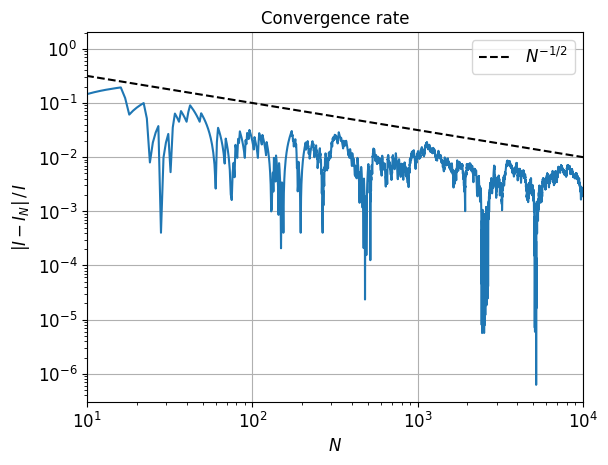

In [8]:
N = 10 ** 4
N_ = np.arange(1, N + 1)

x = get_sample(N, 2)
z = np.linalg.norm(x, axis=1) < 1

true_I = np.pi / 4

errs = np.abs(true_I - z.cumsum() / N_) / true_I

plt.loglog(N_, errs)
plt.loglog(N_, N_ ** -0.5, "k--", label=r"$N^{-1/2}$")
plt.xlim(10, N)
plt.xlabel(r"$N$", size=12)
plt.ylabel(r"$|I - I_N| \,/\, I$", size=12)
plt.grid()
plt.legend(fontsize=12)
plt.title("Convergence rate");

2. **(On the choice of $N$):** By _a priori_ analysis (knowing that $Z\sim \text{Bernoulli}(p)$ with $p=\pi/4$), determine three lower bounds for $N = N(\alpha, \epsilon)$ with $\epsilon =10^{-2}$ and $\alpha = 10^{-4}$ for ensuring that
$$
\mathbb{P}\left(\left| \overline{I}_N - \pi/4 \right| > \epsilon \right) < \alpha
$$
using Chebycheff's inequality (rigorous), the Berry-Esseen Theorem
(rigorous) and the leap of faith
$$
\frac{ \overline{I}_N - \pi/4}{\sqrt{\mathrm{Var}(Z)/N}} \sim N(0,1).
$$

    Discuss the advantages and disadvantages of using each bound.

For determining the respective lower bounds for $N(\alpha, \epsilon)$,
note first that since $Z\sim \text{Bernoulli}(p = \pi/4)$,
we have 

$$
\mathrm{Var}(Z) = \sigma^2 = \mathbb{E}{( Z - p )^2} = p (1-p),
$$

and

$$
\mathbb{E}{ \left |Z-p\right|^3 } = \gamma^3 = (1-p)^3p + p^3(1-p) = p(1-p)\left[(1-p)^2+p^2\right].
$$

When using the **central limit theorem** relation (called "leap of faith" as we are in the non-asymptotic setting), we may bound the probability of failure by

$$
\begin{split}
\mathbb{P}\left(\left |\overline I_N - I\right| \ge \epsilon\right) &= 
\mathbb{P}\left(\sqrt{N} \frac{\left |\overline I_N - I\right|}{\sigma} >
	\frac{\sqrt{N}\epsilon}{\sigma}\right)
= 2\left (1-\Phi\left (\frac{\sqrt{N}\epsilon}{\sigma}\right)\right).
\end{split}
$$

To ensure that 

$$
2\left (1-\Phi\left (\frac{\sqrt{N}\epsilon}{\sigma}\right)\right) < \alpha,
$$
one must use at least 

$$
N_{CLT} (\alpha, \epsilon) =  \left\lceil \left ( \frac{\sigma
		c_{1-\alpha/2}}{\epsilon} \right)^2\right \rceil,
$$

samples, where $\lceil x \rceil := \min\{z \in \mathbb{Z} \mid z \ge x\}$ and $c_{1-\alpha/2}$ is the $1-\alpha/2$ quantile of the standard normal distribution, i.e., $\Phi(c_{1-\alpha/2})=1-\alpha/2$.

When using the **Chebycheff bound**,

$$
\begin{split}
\mathbb{P}\left(\left |\overline I_N - I\right| > \epsilon\right) \le   \frac{\sigma^2}{N \epsilon^2},
\end{split}
$$

to ensure that $\sigma^2/N\epsilon^2 < \alpha$, we have that

$$
N_{CHEB}(\alpha, \epsilon) = \left\lceil \frac{\sigma^2}{ \alpha \epsilon^{2} } \right\rceil , 
$$

ensures that the probability of failure is bounded by $\alpha$.

When relying on the **Berry-Esseen theorem**,
the probability of failure is controlled by

$$
\begin{split}
\mathbb{P}\left(\left |\overline I_N - I\right| > \epsilon \right) & =
\mathbb{P}\left( \sqrt{N}\frac{\left |\overline I_N - I\right|}{\sigma} >
	\frac{\sqrt{N} \epsilon}{\sigma}\right)\\
& \le 2\left (1-\Phi\left (\frac{\sqrt{N} \epsilon}{\sigma} \right) \right) +
\frac{2}{\sqrt{N}}\beta K,
\end{split}
$$

where $K\approx 0.4748$ is the constant in the Berry-Essen inequality, and $\beta = \gamma^3/\sigma^3$.

The lower bound solution can then be viewed as the smallest integer which is larger or equal to
the zero of the equation

$$
f(x) := 1-\Phi\left (\frac{\sqrt{x} \epsilon}{\sigma} \right) +
\frac{ \beta K}{\sqrt{x}} - \frac{\alpha}{2}.
$$

Since $f'<0$ for all $x>0$, the zero is unique. We determine the value of $N_{BE}$ using the Newton method `scipy.optimize.newton`.

For the considered problem setting, we report the obtained numbers below and conclude that

$$
N_{CLT} = 25513 \le N_{CHEB} = 16854789 \le N_{BE} = 235103811.
$$

In [9]:
p = np.pi / 4
var = p * (1 - p)
gamma = p * (1 - p) * ((1 - p) ** 2 + p ** 2)

K = 0.4748   # Berry-Essen constant

In [10]:
def central_limit_bound(alpha: float, eps: float) -> int:
    """
    Calculates the minimum sample size for estimating `π / 4` based on the CLT.
    """
    N = int(np.ceil((np.sqrt(var) * norm.ppf(1 - alpha / 2) / eps) ** 2))
    return N

In [11]:
def chebycheff_bound(alpha: float, eps: float) -> int:
    """
    Calculates the minimum sample size for estimating `π / 4` based on the Chebycheff bound.
    """
    N = int(np.ceil(var / alpha / eps ** 2))
    return N

In [12]:
def berry_essen_bound(alpha: float, eps: float) -> int:
    """
    Calculates the minimum sample size for estimating `π / 4` based on the Berry-Essen theorem.
    """
    helper = lambda x: (
        1 - norm().cdf(np.sqrt(x) * eps / np.sqrt(var)) + K * gamma / np.sqrt(var) ** 3 / np.sqrt(x) - alpha / 2
    )
    x0 = chebycheff_bound(alpha, eps)
    N = int(np.ceil(newton(helper, x0=x0, maxiter=100)))
    return N

In [13]:
alpha = 1e-4
eps = 1e-2

In [14]:
N_CLT = central_limit_bound(alpha, eps)
N_CB = chebycheff_bound(alpha, eps)
N_BE = berry_essen_bound(alpha, eps)

print(f"Central limit bound: N = {N_CLT}")
print(f"Chebycheff bound: {'':<2} N = {N_CB}")
print(f"Berry-Esseen bound: {'':<0} N = {N_BE}")

Central limit bound: N = 25513
Chebycheff bound:    N = 16854789
Berry-Esseen bound:  N = 235103811


3. An important property of the MC method is that, under
very weak regularity assumptions, an $O(N^{-1/2})$
convergence rate holds independently of the dimensionality of the
underlying problem.  To illustrate this, consider approximating $\mathbb{E}[Z]$ as in the first point, for $n=6.$

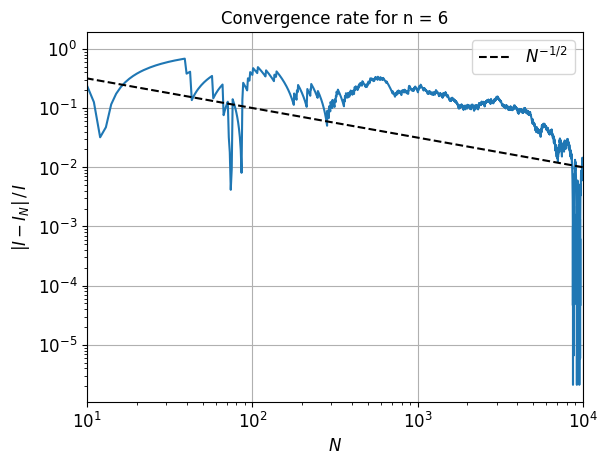

In [15]:
N = 10 ** 4
N_ = np.arange(1, N + 1)

n = 6

x = get_sample(N, n=n)
z = np.linalg.norm(x, axis=1) < 1

vol_sphere = np.pi ** (n / 2) / factorial(n / 2)
vol_gamma = 2 ** n

true_I = vol_sphere / vol_gamma

errs = np.abs(true_I - z.cumsum() / N_) / true_I

plt.loglog(N_, errs)
plt.loglog(N_, N_ ** -0.5, "k--", label=r"$N^{-1/2}$")
plt.xlim(10, N)
plt.xlabel(r"$N$", size=12)
plt.ylabel(r"$|I - I_N| \,/\, I$", size=12)
plt.grid()
plt.legend(fontsize=12)
plt.title(f"Convergence rate for n = {n}");

## Exercise 2

A simulator would like to produce an unbiased estimate of
$\mathbb{E}(XY)$, where the two independent random variables $X$ and
$Y$ have bounded first moments and can be generated by a stochastic
simulation. To this end, she simulates $R\in\mathbb{N}$ replications
$X_1,\dots, X_R$ of $X$ and, independently of this, $R$ replications
$Y_1,\dots, Y_R$ of $Y$. She thus has the following two natural
estimators for $\mathbb{E}(XY)$ at her disposal:

\begin{equation*}
  \text{Est}_1 := \Biggl(\frac{1}{R}\sum_{r=1}^RX_r \Biggr) \Biggl(\frac{1}{R}\sum_{r=1}^RY_r \Biggr)\quad\text{and}\quad \text{Est}_2 := \frac{1}{R}\sum_{r=1}^RX_rY_r\;.
\end{equation*}

1. Verify that both estimators $\text{Est}_1$ and $\text{Est}_2$ are unbiased.

Introducing the notation $\bar X_R = \frac{1}{R} \sum_{i=1}^R X_i$ and $\bar Y_R = \frac{1}{R} \sum_{r=1}^R Y_j$, it holds by the independence of the random variables $X_i$ and $Y_j$, and the identical distribution of elements in the sequence $X_1,X_2, \ldots, X_R$ and ditto for elements in the sequence $Y_1,Y_2, \ldots, Y_R$, that for any $ 1\le i,j \le R$,
  $$
  \mathbb{E}\left[X_i Y_j \right] = \mathbb{E}\left[X_i\right] \mathbb{E}\left[Y_j\right] = \mathbb{E}\left[X\right] \mathbb{E}\left[Y\right] = \mathbb{E}\left[XY\right].
  $$
  Consequently,
  $$
  \mathbb{E}\left[ \bar X_R \bar Y_R \right] = \frac{1}{R^2} \sum_{i,j =1}^R \mathbb{E}\left[X_i Y_j \right]
  =  \frac{1}{R^2} \sum_{i,j =1}^R \mathbb{E}\left[X Y\right] = \mathbb{E}\left[XY\right],
  $$
  and
  $$
  \mathbb{E}\left[ \frac{1}{R} \sum_{r=1}^R X_rY_r \right] = \frac{1}{R} \sum_{r=1}^R \mathbb{E}\left[X Y\right]  = \mathbb{E}\left[XY\right].
  $$

2. Show that $\mathrm{Var}(\text{Est}_1)<\mathrm{Var}(\text{Est}_2)$.

Let us recall first that since the sequence $X_1,X_2,\ldots$ is iid,
  $$
  \mathrm{Var}(\bar X_R) = \text{Cov}(\bar X_R,\bar X_R) = \frac{1}{R} \mathrm{Var}(X), 
  $$
  and
  $$
  \mathbb{E}\left[\bar X_R\right] = \mathbb{E}\left[X\right].
  $$
  (And, similarly, $ \mathrm{Var}(\bar Y_R) = \frac{1}{R}\mathrm{Var}(Y), \quad \mathbb{E}\left[\bar Y_R\right] = \mathbb{E}\left[Y\right].)$

  Using that $\bar X_R$ and $\bar Y_R$ are independent, 
  $$
  \begin{split}
    \mathrm{Var}(\text{Est}_1) &= \mathbb{E}\left[\bar X_R^2 \bar Y_R^2\right] - \left[\mathbb{E}{\bar X_R \bar Y_R}\right]^2\\
    &=\mathbb{E}\left[\bar X_R^2\right] \mathbb{E}\left[\bar Y_R^2\right] - \left( \mathbb{E}\left[\bar X_R\bar Y_R\right]\right)^2\\
      & = \left(\mathrm{Var}(\bar X_R) + \mathbb{E}\left[\bar X_R\right]^2 \right)
      \left(\mathrm{Var}(\bar Y_R) + \mathbb{E}\left[\bar Y_R\right]^2 \right) - \mathbb{E}\left[\bar X_R \bar Y_R\right]^2\\
      & = \mathrm{Var}(\bar X_R)\mathrm{Var}(\bar Y_R) + \mathrm{Var}(\bar X_R)\mathbb{E}\left[\bar Y_R\right]^2
      + \mathrm{Var}(\bar Y_R)\mathbb{E}\left[\bar X_R\right]^2\\
      & = \frac{1}{R^2}\mathrm{Var}(X)\mathrm{Var}(Y) + \frac{1}{R}\mathrm{Var}(X) \mathbb{E}\left[Y\right]^2 +
      \frac{1}{R}\mathrm{Var}(Y)\mathbb{E}\left[X\right]^2. 
      \end{split}
  $$
  And for the second estimator we use that since the sequence $X_1Y_1,X_2Y_2,\ldots$
  is i.i.d, we may argue as above to derive that 
  $$
  \mathrm{Var}(\text{Est}_2) = \frac{1}{R} \mathrm{Var}(XY)
  = \frac{1}{R} \mathrm{Var}(X)\mathrm{Var}(Y) + \mathrm{Var}(X) \mathbb{E}\left[Y\right]^2 + \mathrm{Var}(Y)\mathbb{E}\left[X\right]^2.
  $$
  So whenever $\mathrm{Var}(X)\mathrm{Var}(Y)>0$,
  $$
  \mathrm{Var}(\text{Est}_2) -\mathrm{Var}(\text{Est}_1) = \mathrm{Var}(X)\mathrm{Var}(Y)\frac{R-1}{R^2} > 0.
  $$

3. Use the delta method to show that $\sqrt{R}(\text{Est}_1-\mu_x\mu_y)\overset{d}{\rightarrow}N(0,\tau^2)$. Find $\tau^2$ explicitly and derive a $1-\alpha$ asymptotic confidence interval. 

We have that, 
   \begin{equation*}
   \sqrt{R} \left(\left[\begin{array}{c} \bar{X}_R \\ \bar{Y}_R\end{array}\right] - \left[\begin{array}{c} \mu_x \\ \mu_y  \end{array}\right]\right) \to N(0, \Sigma),
   \end{equation*}
   where $\Sigma = \left[\begin{array}{cc} \textrm{var}(X) & 0 \\ 0 & \textrm{var}(Y)\end{array}\right]$. Then for $h(x, y) = xy$, and after applying the delta method, we get that 
   \begin{equation*}
   \sqrt{R} \left(h(\bar{X}, \bar{Y}) - \mu_x\mu_y\right) \to N(0, \tau^2)
   \end{equation*}
   with $\tau^2 = [\mu_y, \mu_x] \Sigma \left[\begin{array}{c}\mu_y \\ \mu_x\end{array}\right] = \textrm{Var}(X)\mathbb{E}[Y]^2 + \textrm{Var}(Y)\mathbb{E}[X]^2$. The confidence interval then follows easily.

## Exercise 3

Algorithm 1 proposes a sequential Monte Carlo method to compute the expectation $\mathbb{E}[X]$ of a random variable $X$, where the sample size is doubled at each iteration until the estimated $1-\alpha$ confidence interval based on a central limit theorem approximation is smaller than a prescribed tolerance $\epsilon$. The algorithm then outputs the final sample size $N(\epsilon,\alpha)$, as well as the estimated value $\bar X_N$.

---
**Algorithm 1** Sample Variance Based SMC

- **Input:** $N_0$, distribution $\lambda$, accuracy $\epsilon>0$, confidence $1-\alpha>0$.
- **Output:** $\overline X_{\epsilon,\alpha} $ (i.e., approximation of $\mathbb E [ X]$ with $X\sim\lambda$), $N$.

- Set $k=0$, generate $N_k$ i.i.d. replicas $\{X_i\}_{i=1}^{N_k}$ of $X\sim\lambda$ and 
	\begin{equation}\tag{1}
	\bar{X}_{N_k}=\frac{1}{N_k}\sum_{i=1}^{N_k}X_i,
	\end{equation}
	
    \begin{equation}\tag{2}
    \overline \sigma^2_{N_k} := \frac{1}{N_k-1} \sum_{i=1}^{N_k} (X_i -\overline X_{N_k})^2.
    \end{equation}

- **while** $\bar{\sigma}_{N_k}C_{1-\alpha/2}/\sqrt{N_k} > \epsilon$ **do**
    - Set $k =k+1$ and $N_{k}=2N_{k-1}$.
    - Generate a new batch of $N_k$ i.i.d. replicas $\{X_i\}_{i=1}^{N_k}$ of $X\sim \lambda$.
    - Compute the sample variance $\overline \sigma^2_{N_k}$ by (2).
- **end while**

- Set $N =N_k$, generate i.i.d. samples $\{X_i\}_{i=1}^{N}$ of $\lambda$ and compute the output sample mean $\overline X_{\epsilon,\alpha}$.

---

Algorithm 1 can be particularly sensitive to the choice of initial sample size $N_0$, and as such, we would like to assess the robustness of such an algorithm in estimating $\mathbb{E}[ X]$ for different distributions of $X$. For some values of $N_0$ ranging between $10$ and $50$,  consider $\alpha = 10^{-1.5}$ and $\epsilon =1/10$, and the following random variables:

1. $X \sim \text{Pareto}(x_m=1,\gamma=3.1)$ (i.e. with PDF $p(y) = \mathbb{1}_{y>x_m} x_m^\gamma \gamma y^{-(\gamma+1)}$), $\,\mathbb{E}[X]=\frac{\gamma x_m}{\gamma-1}.$
2. $X \sim \text{Lognormal}(\mu=0,\sigma=1)$,  $\,\mathbb{E}[X]=\exp\left(\mu+\frac{\sigma^2}{2}\right).$
3. $X \sim U([-1,1]),$ $\,\mathbb{E}[X]=0$.

Repeat the simulation $K=20\alpha^{-1}$ times and record the sample sizes $\{N^{(i)}\}_{i=1}^K$ as well as the computed sample means $\{\bar{X}_{\epsilon,\alpha}^{(i)}\}_{i=1}^K$ returned by the algorithm for each run $i=1,...,K$. Estimate the probability of failure $\overline p$ of the algorithm:

$$
\large
\overline p_K(N_0,\epsilon,\alpha)=\frac{1}{K}\sum_{i=1}^{K}\mathbb{1}_{|\bar{X}^{(i)}_{\epsilon, \alpha}-\mathbb{E}[X]|>\epsilon}.
$$

Then check whether  $\overline p_K(N_0,\epsilon,\alpha) \le \alpha$ holds. Repeat your experiment for different values of $\epsilon$ and $\alpha$. Discuss your results. 

**Hint 1:** You may generate Pareto$(x_m,\alpha)$ r.v. by inversion or have a look at [`scipy.stats.pareto`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pareto.html).

**Hint 2:** The specified type hint [`rv_continuous`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html) for the `dist` argument within the `algorithm_1` function down below indicates that you have the flexibility to use any of [SciPy's continous distributions](https://docs.scipy.org/doc/scipy/tutorial/stats/continuous.html). For instance, you can pass `dist=pareto(b=3.1)` or `dist=lognorm(s=1)`. Of course, while this is only one of many possible solutions, it allows a modular code implementation.

Notice that since $\mathbb{E}[\bar{p}_N]\sim \alpha$, $\mathrm{Var}[\bar p_N]\sim \alpha(1-\alpha)/N\sim \alpha/N$, the choice $N=20\alpha^{-1}$ gives a 95\% confidence interval $\alpha\pm \frac{\sqrt{\alpha}}{\sqrt{N}}C_{1-\alpha/2}\sim \alpha\left(1\pm \frac{C_{1-\alpha/2}}{\sqrt{20}}\right)$. The results of the numerical tests are plotted in the following Figures.

For the estimate of $\overline p_N$ 
we have included errorbars
of magnitude $\sigma_N := 2\sqrt{\overline p_N(1-\overline p_N)/N}$
for all three distributions.
Random variables from the Pareto distribution can be sampled using inversion sampling with $F^{-1}(x) = (1-x)^{-1/3.1}$.
For Algorithm 1, we observe that only the heavy-tailed Pareto($x_m=1,\alpha=3.1$) distribution fails to approximate its mean with the sought confidence as $p_N-2 \sigma_N > \delta$ for all $N_0$-values (and the failure is more pronounced for lower $N_0$-values), while for the other two distributions, one always has $p_N + 2\sigma_N < \delta$.

In [16]:
def algorithm_1(n: int, dist: rv_continuous, alpha: float, eps: float) -> Tuple[float, int]:
    """
    Estimates the mean of a random variable with distribution `dist` using the SMC Algorithm 1.
    Returns the estimated mean and the final sample size.
    """
    x = dist.rvs(n)
    sigma = np.std(x, ddof=1)

    while sigma * norm.ppf(1 - alpha / 2) / np.sqrt(n) > eps:
        n *= 2
        x = dist.rvs(size=n)
        sigma = np.std(x, ddof=1)

    mean = x.mean()

    return mean, n

In [17]:
def prob_of_failure(algo: Callable, n: int, dist: rv_continuous, alpha: float, eps: float) -> float:
    """
    Estimates the probability of failure for a given algorithm.
    """
    K = int(20 * alpha ** -1)

    sample_means = np.zeros(K)
    sample_sizes = np.zeros(K)
    for i in tqdm(range(K)):
        mean, size = algo(n, dist, alpha, eps)
        sample_means[i] = mean
        sample_sizes[i] = size

    true_mean = dist.expect()
    p = (np.abs(sample_means - true_mean) > eps).mean()

    return p

In [18]:
def plot_probs_of_failure(probs: np.array, alpha: float):
    """Plots estimated oribabilities of failure with errorbars."""
    K = int(20 * alpha ** -1)
    err_bars = 2 * np.sqrt(probs * (1 - probs) / K)

    labels = ["Pareto", "Lognormal", "Uniform"]
    for i in range(len(dists)):
        plt.errorbar(ns, probs[:, i], yerr=err_bars[:, i], label=labels[i])
    
    plt.plot(ns, len(ns) * [alpha], "k--", label=r"$\alpha$")
    plt.xlabel(r"$N_0$")
    plt.ylabel(r"$\bar{p}_N$")
    plt.legend()

In [19]:
alpha = 10 ** (-1.5)
eps = 1e-1

dists = [
    pareto(b=3.1),
    lognorm(s=1),
    uniform(loc=-1, scale=2),
]

ns = np.arange(10, 50 + 1, 10)

In [20]:
probs_alg_1 = np.zeros((len(ns), len(dists)))
for i, dist in enumerate(dists):
    for j, n in enumerate(ns):
        probs_alg_1[j, i] = prob_of_failure(algorithm_1, n, dist, alpha, eps)

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

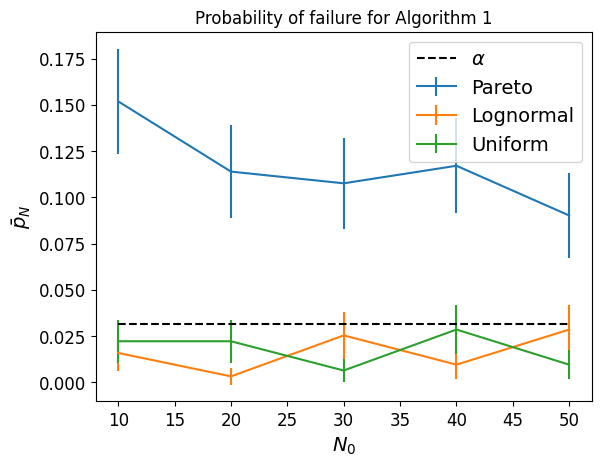

In [21]:
plot_probs_of_failure(probs_alg_1, alpha)
plt.title("Probability of failure for Algorithm 1");

## Exercise 4

Compare Algorithm 1 with the sequential Monte Carlo method in Algorithm 2, where one realization is added at a time. 

---
**Algorithm 2** One-at-a-time Sample Variance Based SMC

- **Input:** $N_0$, distribution $\lambda$, accuracy $\epsilon>0$, confidence $1-\alpha>0$.
- **Output:** $\overline X_{\epsilon,\alpha} $ (i.e, approximation of $\mathbb E [ X]$ with $X\sim\lambda$), $N$.

- Set $k=0$, generate $N_k$ i.i.d. samples $\{X_i\}_{i=1}^{N_k}$ of $\lambda$ and compute the sample variance 
    $$
    \overline \sigma^2_{N_k} := \frac{1}{N_k-1} \sum_{i=1}^{N_k} (X_i -\overline{X}_{N_k})^2.
    $$

- **while** $\bar{\sigma}_{N_k}C_{1-\alpha/2}/\sqrt{N_k} > \epsilon$ **do**
    - Set $k =k+1$ and $N_{k}=N_{k-1} + 1$.
    - Generate a new  i.i.d. sample $X^{(N_k+1)}$ of $\lambda$.
    - Compute\begin{align}
\bar{\mu}_{N_k+1}&=\frac{N_k}{N_k+1}\bar{\mu} +\frac{1}{N_k+1}X^{(N_k+1)}\\
\bar\sigma^2_{N_k+1}&=\frac{N_k-1}{N_k}\sigma^2_{N_k}+
\frac{1}{N_k+1}(X^{(N_k+1)}-\bar\mu_{N_k})^2
		\end{align}
- **end while**

- Set $N =N_k$, generate i.i.d. samples $\{X_i\}_{i=1}^{N}$ of $\lambda$ and compute the output sample mean $\overline X_{\epsilon,\alpha}$.

---


In [22]:
def algorithm_2(n: int, dist: rv_continuous, alpha: float, eps: float) -> Tuple[float, int]:
    """
    Estimate the mean of a random variable with distirbution `dist` using the SMC Algorithm 2.
    Returns the estimated mean and the final sample size.
    """
    x = dist.rvs(n)
    mean = np.mean(x)
    sigma = np.var(x, ddof=1)

    while np.sqrt(sigma) * norm.ppf(1 - alpha / 2) / np.sqrt(n) > eps:
        n += 1
        x = dist.rvs(size=1)[0]
        mean = (n * mean + x) / (n + 1)       
        sigma = (n - 1) / n * sigma + (x - mean) ** 2 / (n + 1)

    return mean, n

When using Algorithm 2, the Pareto distribution once again fails to approximate the mean for all $N_0$ but the failure rate of the algorithm is higher for a given $N_0$ than Algorithm 1. 
We also observe that the algorithm fails to approximate the mean for all $N_0$ for the other distributions as well. 

**Note:** Due to adding one sample at a time in Algorithm 2, the following cell needs a bit longer to compute (approx. 8 min).

In [23]:
probs_alg_2 = np.zeros((len(ns), len(dists)))
for i, dist in enumerate(dists):
    for j, n in enumerate(ns):
        probs_alg_2[j, i] = prob_of_failure(algorithm_2, n, dist, alpha, eps)

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

  0%|          | 0/632 [00:00<?, ?it/s]

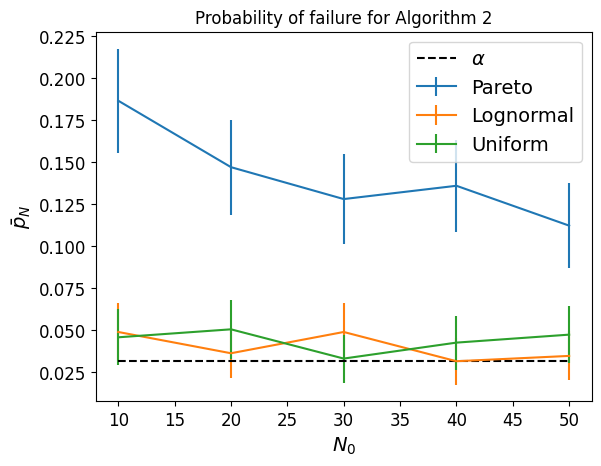

In [23]:
plot_probs_of_failure(probs_alg_2, alpha)
plt.title("Probability of failure for Algorithm 2");